In [1]:
%matplotlib inline

import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt
from sklearn.metrics import precision_recall_fscore_support

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, GRU, Dense
from tensorflow.keras.initializers import Constant
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
def read_and_split(filename, train_X, train_Y, validation_X, validation_Y, test_X, test_Y, label, n=5332):
    '''
    reads data from the input file and splits it into training (60%), validation (20%), and testing (20%) datasets.
    
    Args:
        filename (str): name of the input file
        train_X (List[str]): training samples
        train_Y (List[int]): training labels
        validation_X (List[str]): validation samples
        validation_Y (List[int]): validation labels
        test_X (List[str]): test samples
        test_Y (List[int]): test labels
        label (int): true label
        n (int): number of samples
    
    Returns:
        None
    '''
    
    with open(str(dataset_path / filename), 'rt') as f:
        
        # training data
        for _ in range(int(0.6*n)):
            train_X.append(f.readline())
            train_Y.append(label)
            
        # validation data
        for _ in range(int(0.6*n), int(0.8*n)):
            validation_X.append(f.readline())
            validation_Y.append(label)
            
        # testing data
        for _ in range(int(0.8*n), n):
            test_X.append(f.readline())
            test_Y.append(label)

In [3]:
def get_model(variant, batch_size, hidden_neurons, SEQ_LEN, learning_rate):
    '''
    does padding based pre-processing, creates a new Keras model, fits the data, and plots the result

    Args:
        variant (str): Vanilla RNN, LSTM or GRU network
        batch_size (int): size of each batch when training for each epoch
        hidden_neurons (int): number of hidden neurons for the network
        SEQ_LEN (int): length of the input to consider each time
        learning_rate (int): How big the weight updates for the model should be

    Returns:
        model (Keras model object): the model that was trained with the given RNN variant
        test_padded (List[str]): padded test data depending upon the sequence length
    '''
    
    # zero padding for each of the data sample based on the sequence length
    train_padded = pad_sequences(train_seq, padding='post', maxlen=SEQ_LEN)
    validation_padded = pad_sequences(validation_seq, padding='post', maxlen=SEQ_LEN)
    test_padded = pad_sequences(test_seq, padding='post', maxlen=SEQ_LEN)
            
    # simple sequential Keras model
    model = Sequential()
    
    # embedding to convert the text input to a dense vector based on the glove word representation
    model.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=300, 
                        embeddings_initializer=Constant(embedding_matrix), mask_zero=True, 
                        input_length=SEQ_LEN, trainable=False))
    
    # main layer depending on the flavor of RNN chosen
    if variant == 'vanilla_rnn':
        model.add(SimpleRNN(units=hidden_neurons))
    elif variant == 'lstm':
        model.add(LSTM(units=hidden_neurons))
    else:
        model.add(GRU(units=hidden_neurons))
    
    # output layer with sigmoid activation to get probabilistic output
    model.add(Dense(units=1, activation='sigmoid'))
    
    # we use binary crossentropy to measure the loss and the Adam optimizer
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=learning_rate), metrics=['accuracy'])
    print(model.summary())
    
    # early stopping criteria when the valdiation loss starts increasing
    stopping_criteria = EarlyStopping(patience=2, verbose=1)
    
    # taining the model for around 15 epochs.
    history = model.fit(x=train_padded, y=train_Y, batch_size=batch_size, epochs=15,
                        verbose=2, callbacks=(stopping_criteria), validation_data=(validation_padded, validation_Y))
    
    # plotting the training accuracy and the validation accuracy from the model against number of epochs
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    
    # plotting the training loss and the validation loss from the model against number of epochs
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

    return model, test_padded

In [4]:
def run_on_test(variant, model, test_padded):
    '''
    runs the model on the test data and calculates precision, recall, and F1-score

    Args:
        variant (str): Vanilla RNN, LSTM or GRU network
        model (Keras model object): the model that was trained with the given RNN variant
        test_padded (List[str]): padded test data depending upon the sequence length

    Returns:
        None
    '''
    
    print(f'Result on the test set for RNN variant - {variant}:')
    
    # running the model on the test data
    print('\nTest loss and accuracy is:')
    model.evaluate(x=test_padded, y=test_Y)
    test_pred = (model.predict(test_padded) > 0.5).astype(dtype=np.int8)
    precision, recall, fscore, _ = precision_recall_fscore_support(y_true=test_Y, y_pred=test_pred, average='binary')
    print(f'\nPrecision: {precision} \nRecall: {recall} \nF1-Score: {fscore}')

In [5]:
# set the path for the dataset and word embedding
cur_dir = Path.cwd()
dataset_path = cur_dir / 'Dataset' / 'rt-polaritydata'
embeddings_path = cur_dir / 'word_representations' / 'glove.6B' / 'glove.6B.300d.txt'
      
# initialize and and fill the data and labels list
train_X, train_Y, validation_X, validation_Y, test_X, test_Y = [], [], [], [], [], []            
read_and_split('rt-polarity.pos', train_X, train_Y, validation_X, validation_Y, test_X, test_Y, label=1)
read_and_split('rt-polarity.neg', train_X, train_Y, validation_X, validation_Y, test_X, test_Y, label=0)

# convert lists to numpy arrays and reshape appropriately
train_Y = np.asarray(train_Y, dtype=np.int8).reshape((-1, 1))
validation_Y = np.asarray(validation_Y, dtype=np.int8).reshape((-1, 1))
test_Y = np.asarray(test_Y, dtype=np.int8).reshape((-1, 1))

# initialize tokenizer and fit it on the training samples
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_X)

# get encoded samples based on the fitting
train_seq = tokenizer.texts_to_sequences(train_X)
validation_seq = tokenizer.texts_to_sequences(validation_X)
test_seq = tokenizer.texts_to_sequences(test_X)

# read the embeddings file and create an embedding dictionary
embeddings_index = {}
with open(str(embeddings_path), 'rt', encoding='utf-8') as f:
    for line in f.readlines():
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, 'f', sep=' ')
        embeddings_index[word] = coefs       
        
# get an embedding matrix from the dictionary
embedding_matrix = np.zeros((len(tokenizer.word_index)+1, 300))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[index, :] = embedding_vector

# Training runs:

* The model used is sequential model that has mask_zero set to True in order to get the hidden state corresponding to the last word in the sentence (ignoring padding).
* Also, I have set an early stopping criteria, so if the validation loss does not improve after at max 2 epochs, the training is halted right there. Hence, even though the epoch limit is set to 15, some training runs stop way before that.
* The vanilla RNN model has been run on the training dataset for a total of **9 times** using different hyper-parameters.
* First run consists of the one with the most optimal parameters.
* Result for each of the run is discussed accordingly.
* After finding the optimal parameters for the vanilla RNN, the same hyper-paramters have been used for the LSTM and GRU models.
* Finally, I have passed the testing data to the model of each variant. Results for testing are discussed at the end.

## Vanilla RNN run 1 (most optimal):

* This run uses the right balance of the batch size, number of hidden neurons, sequence length, and learning rate.
* We will observe later on what happens when these parameters are changed, and how they affect the training.
* For the vanilla RNN these parameters leads to a good 70% plus validation accuracy.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 51, 300)           4524300   
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 75)                28200     
_________________________________________________________________
dense (Dense)                (None, 1)                 76        
Total params: 4,552,576
Trainable params: 28,276
Non-trainable params: 4,524,300
_________________________________________________________________
None
Epoch 1/15
64/64 - 2s - loss: 0.7359 - accuracy: 0.5030 - val_loss: 0.7111 - val_accuracy: 0.5347
Epoch 2/15
64/64 - 1s - loss: 0.6942 - accuracy: 0.5503 - val_loss: 0.6906 - val_accuracy: 0.5539
Epoch 3/15
64/64 - 1s - loss: 0.6650 - accuracy: 0.5960 - val_loss: 0.6710 - val_accuracy: 0.5877
Epoch 4/15
64/64 - 1s - loss: 0.6344 - accuracy: 0.6413 - val_loss: 0.63

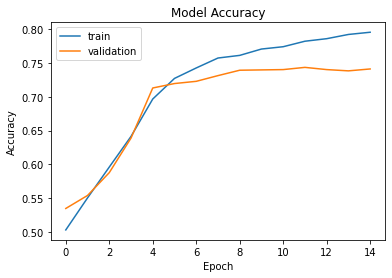

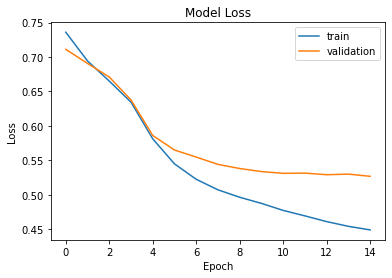

In [6]:
# Vanilla RNN model run 1

model_RNN, test_padded_RNN = get_model(variant='vanilla_rnn', batch_size=100, 
                                       hidden_neurons=75, SEQ_LEN=51, learning_rate=0.0001)

## Vanilla RNN run 2 (smaller batch size):

* Here the batch size is significantly decreased, from 100 to just 10.
* We can see that this model also achieves average results on the validation set, sometimes slightly closer to the ideal run.
* But, since the batch size is small each epoch takes a lot of time to run (6-7 seconds compared to 1-2 seconds seen previously).
* It is because here the model has to udpate the weights more number of times in each epoch, requiring more time.
* This is undesireable since we have similar result but with much slower training.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 51, 300)           4524300   
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 75)                28200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 76        
Total params: 4,552,576
Trainable params: 28,276
Non-trainable params: 4,524,300
_________________________________________________________________
None
Epoch 1/15
640/640 - 5s - loss: 0.6950 - accuracy: 0.5667 - val_loss: 0.6514 - val_accuracy: 0.6201
Epoch 2/15
640/640 - 5s - loss: 0.5711 - accuracy: 0.7099 - val_loss: 0.6294 - val_accuracy: 0.6637
Epoch 3/15
640/640 - 5s - loss: 0.5171 - accuracy: 0.7477 - val_loss: 0.5468 - val_accuracy: 0.7242
Epoch 4/15
640/640 - 5s - loss: 0.4948 - accuracy: 0.7627 - val_

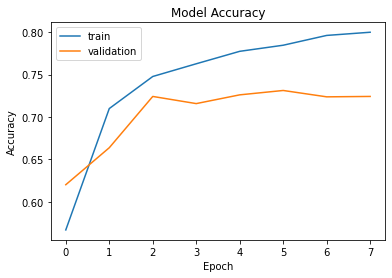

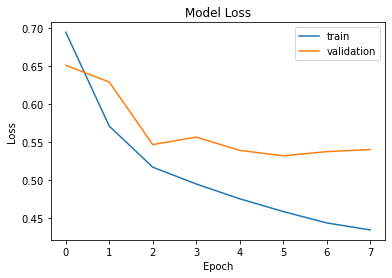

In [7]:
# Vanilla RNN model run 2

model_2, test_padded_2 = get_model(variant='vanilla_rnn', batch_size=10, hidden_neurons=75, SEQ_LEN=51, learning_rate=0.0001)

## Vanilla RNN run 3 (larger batch size):

* Here, we get slightly lower validation accuracies than the ideal run.
* Larger batch size means weights are updated less frequently. So even if each epoch runs faster, it is not preferable to set the batch size too large.
* Hence, we set the batch size somewhere in the middle (100). The result can be seen in run 1.

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 51, 300)           4524300   
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 75)                28200     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 76        
Total params: 4,552,576
Trainable params: 28,276
Non-trainable params: 4,524,300
_________________________________________________________________
None
Epoch 1/15
26/26 - 1s - loss: 0.7513 - accuracy: 0.4839 - val_loss: 0.7258 - val_accuracy: 0.5084
Epoch 2/15
26/26 - 1s - loss: 0.7187 - accuracy: 0.5239 - val_loss: 0.7099 - val_accuracy: 0.5300
Epoch 3/15
26/26 - 1s - loss: 0.6967 - accuracy: 0.5520 - val_loss: 0.6982 - val_accuracy: 0.5511
Epoch 4/15
26/26 - 1s - loss: 0.6784 - accuracy: 0.5756 - val_loss: 0.

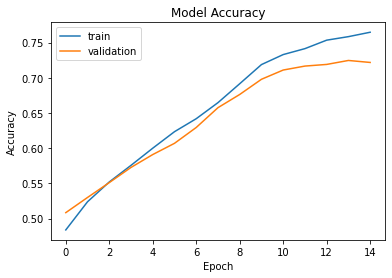

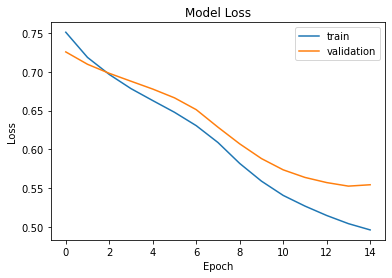

In [8]:
# Vanilla RNN model run 3

model_3, test_padded_3 = get_model(variant='vanilla_rnn', batch_size=250, hidden_neurons=75, SEQ_LEN=51, learning_rate=0.0001)

## Vanilla RNN run 4 (less number of neurons):

* We have set the number of neurons to 30.
* The number of neurons are low, so the model is unable to learn a lot from the data.
* This can be seen in the overall lower (peak) accuracy both on the training and the validation dataset.
* We need to increase the hidden neurons so that the model can learn more and generalize from the training dataset.

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 51, 300)           4524300   
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 30)                9930      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 31        
Total params: 4,534,261
Trainable params: 9,961
Non-trainable params: 4,524,300
_________________________________________________________________
None
Epoch 1/15
64/64 - 1s - loss: 0.7354 - accuracy: 0.5008 - val_loss: 0.7357 - val_accuracy: 0.4986
Epoch 2/15
64/64 - 1s - loss: 0.7122 - accuracy: 0.5206 - val_loss: 0.7195 - val_accuracy: 0.5098
Epoch 3/15
64/64 - 1s - loss: 0.6959 - accuracy: 0.5438 - val_loss: 0.7081 - val_accuracy: 0.5174
Epoch 4/15
64/64 - 1s - loss: 0.6834 - accuracy: 0.5614 - val_loss: 0.6

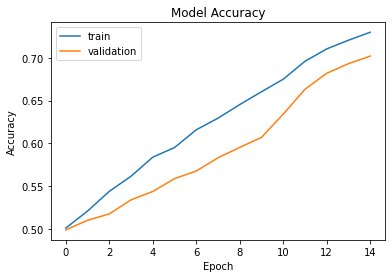

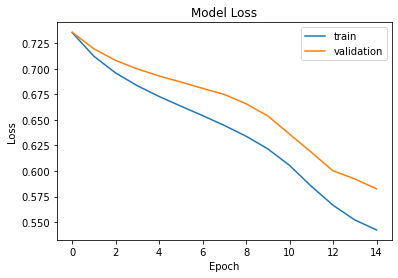

In [9]:
# Vanilla RNN model run 4

model_4, test_padded_4 = get_model(variant='vanilla_rnn', batch_size=100, hidden_neurons=30, SEQ_LEN=51, learning_rate=0.0001)

## Vanilla RNN run 5 (more number of neurons):

* This model learns relatively well from the training data.
* But it is still not desireable as the model starts over-fitting on the training data.
* We can observe the gap between training loss and validation loss is a lot wider.
* So, I finally settled on around 75 neurons for the optimal parameters.

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 51, 300)           4524300   
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, 150)               67650     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 151       
Total params: 4,592,101
Trainable params: 67,801
Non-trainable params: 4,524,300
_________________________________________________________________
None
Epoch 1/15
64/64 - 2s - loss: 0.7113 - accuracy: 0.5389 - val_loss: 0.6908 - val_accuracy: 0.5713
Epoch 2/15
64/64 - 2s - loss: 0.6492 - accuracy: 0.6150 - val_loss: 0.6506 - val_accuracy: 0.6271
Epoch 3/15
64/64 - 2s - loss: 0.5786 - accuracy: 0.6977 - val_loss: 0.5908 - val_accuracy: 0.6820
Epoch 4/15
64/64 - 2s - loss: 0.5325 - accuracy: 0.7394 - val_loss: 0.

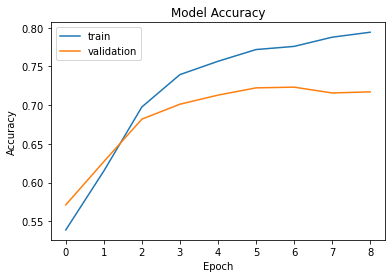

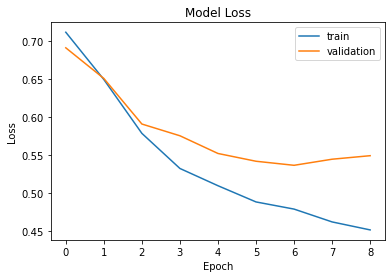

In [10]:
# Vanilla RNN model run 5

model_5, test_padded_5 = get_model(variant='vanilla_rnn', batch_size=100, hidden_neurons=150, SEQ_LEN=51, learning_rate=0.0001)

## Vanilla RNN run 6 (shorter sequence length):

* In the ideal run (1), we set the sequence length as the longest sentence in our dataset.
* Even after halving the sequence, we can still observe good results on the validation dataset.
* Even if the accuracies are not equal to or greater than the first run, the results are surprising as we are cutting away almost half the information in the sequence for most samples.

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 25, 300)           4524300   
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 75)                28200     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 76        
Total params: 4,552,576
Trainable params: 28,276
Non-trainable params: 4,524,300
_________________________________________________________________
None
Epoch 1/15
64/64 - 1s - loss: 0.7128 - accuracy: 0.5356 - val_loss: 0.7037 - val_accuracy: 0.5272
Epoch 2/15
64/64 - 1s - loss: 0.6815 - accuracy: 0.5747 - val_loss: 0.6871 - val_accuracy: 0.5525
Epoch 3/15
64/64 - 1s - loss: 0.6560 - accuracy: 0.6063 - val_loss: 0.6660 - val_accuracy: 0.5858
Epoch 4/15
64/64 - 1s - loss: 0.6220 - accuracy: 0.6504 - val_loss: 0.

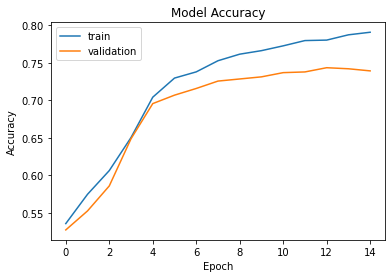

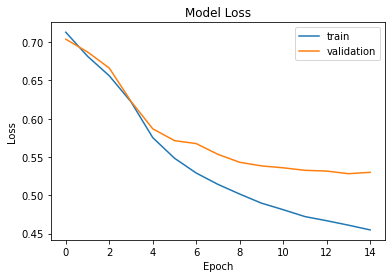

In [11]:
# Vanilla RNN model run 6

model_6, test_padded_6 = get_model(variant='vanilla_rnn', batch_size=100, hidden_neurons=75, SEQ_LEN=25, learning_rate=0.0001)

## Vanilla RNN run 7 (longer sequence length):

* Since, we are ignoring the padding for our model, the results here are similar to the first run.
* This can also be seen in the number of trainable parameters.
* Hence, there does't seem to be much of a point in increasing the sequence length of the data.

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 100, 300)          4524300   
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, 75)                28200     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 76        
Total params: 4,552,576
Trainable params: 28,276
Non-trainable params: 4,524,300
_________________________________________________________________
None
Epoch 1/15
64/64 - 3s - loss: 0.7147 - accuracy: 0.5369 - val_loss: 0.7032 - val_accuracy: 0.5399
Epoch 2/15
64/64 - 2s - loss: 0.6781 - accuracy: 0.5780 - val_loss: 0.6822 - val_accuracy: 0.5680
Epoch 3/15
64/64 - 3s - loss: 0.6497 - accuracy: 0.6200 - val_loss: 0.6576 - val_accuracy: 0.6051
Epoch 4/15
64/64 - 3s - loss: 0.6123 - accuracy: 0.6665 - val_loss: 0.

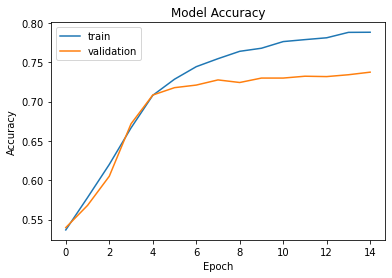

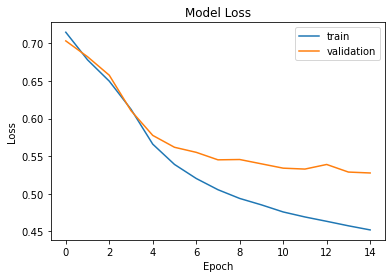

In [12]:
# Vanilla RNN model run 7

model_7, test_padded_7 = get_model(variant='vanilla_rnn', batch_size=100, hidden_neurons=75, SEQ_LEN=100, learning_rate=0.0001)

## Vanilla RNN run 8 (bigger learning rate):

* As can be seen, the loss keeps going down and then up, indicating that the model might be over-shooting the global optimal point.
* Hence, the training seems instable and the loss difference between training and validation keeps getting wider.
* Inshort, it is better to not keep the learning rate too high.

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 51, 300)           4524300   
_________________________________________________________________
simple_rnn_7 (SimpleRNN)     (None, 75)                28200     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 76        
Total params: 4,552,576
Trainable params: 28,276
Non-trainable params: 4,524,300
_________________________________________________________________
None
Epoch 1/15
64/64 - 2s - loss: 0.6382 - accuracy: 0.6304 - val_loss: 0.5747 - val_accuracy: 0.6989
Epoch 2/15
64/64 - 1s - loss: 0.5131 - accuracy: 0.7502 - val_loss: 0.5388 - val_accuracy: 0.7322
Epoch 3/15
64/64 - 1s - loss: 0.4893 - accuracy: 0.7676 - val_loss: 0.5310 - val_accuracy: 0.7369
Epoch 4/15
64/64 - 1s - loss: 0.4505 - accuracy: 0.7871 - val_loss: 0.

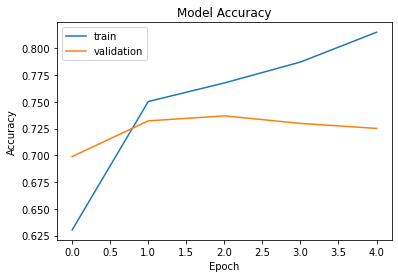

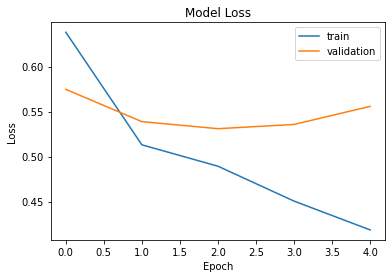

In [13]:
# Vanilla RNN model run 8

model_8, test_padded_8 = get_model(variant='vanilla_rnn', batch_size=100, hidden_neurons=75, SEQ_LEN=51, learning_rate=0.001)

## Vanilla RNN run 9 (smaller learning rate):

* When the learning rate is too small, the weight updates are also too small, so the model doesn't make much progress on the loss and accuracies.
* Even after 15 epochs, the loss is still relatively high. We would have to train for many more epochs to reach near our ideal accuracies.
* So keeping the learning rate too small is never recommended.

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 51, 300)           4524300   
_________________________________________________________________
simple_rnn_8 (SimpleRNN)     (None, 75)                28200     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 76        
Total params: 4,552,576
Trainable params: 28,276
Non-trainable params: 4,524,300
_________________________________________________________________
None
Epoch 1/15
64/64 - 2s - loss: 0.7393 - accuracy: 0.5041 - val_loss: 0.7454 - val_accuracy: 0.5033
Epoch 2/15
64/64 - 1s - loss: 0.7337 - accuracy: 0.5091 - val_loss: 0.7412 - val_accuracy: 0.5056
Epoch 3/15
64/64 - 1s - loss: 0.7286 - accuracy: 0.5134 - val_loss: 0.7372 - val_accuracy: 0.5070
Epoch 4/15
64/64 - 1s - loss: 0.7238 - accuracy: 0.5175 - val_loss: 0.

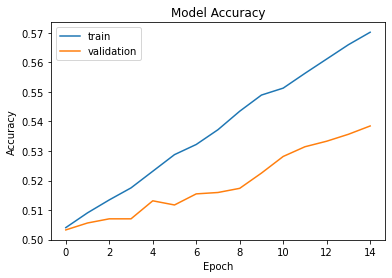

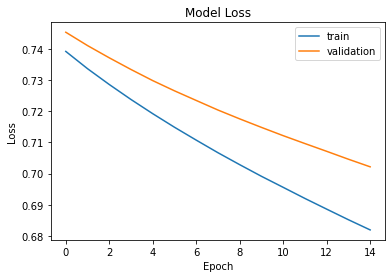

In [14]:
# Vanilla RNN model run 9

model_9, test_padded_9 = get_model(variant='vanilla_rnn', batch_size=100, hidden_neurons=75, SEQ_LEN=51, learning_rate=0.00001)

## LSTM (with RNN's optimal parameters):

* Even after using the same parameters as from our RNN model, we can see significant bump in the model accuracy on the validation set.
* But the number of trainable parameters for this model is significantly higher than the vanilla RNN model.
* This is due to the behavior of LSTM to remember long term dependencies in the data samples.

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 51, 300)           4524300   
_________________________________________________________________
lstm (LSTM)                  (None, 75)                112800    
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 76        
Total params: 4,637,176
Trainable params: 112,876
Non-trainable params: 4,524,300
_________________________________________________________________
None
Epoch 1/15
64/64 - 3s - loss: 0.6796 - accuracy: 0.5860 - val_loss: 0.6655 - val_accuracy: 0.6051
Epoch 2/15
64/64 - 3s - loss: 0.6420 - accuracy: 0.6668 - val_loss: 0.6263 - val_accuracy: 0.6623
Epoch 3/15
64/64 - 3s - loss: 0.5840 - accuracy: 0.7054 - val_loss: 0.5720 - val_accuracy: 0.7054
Epoch 4/15
64/64 - 3s - loss: 0.5404 - accuracy: 0.7380 - val_loss: 0

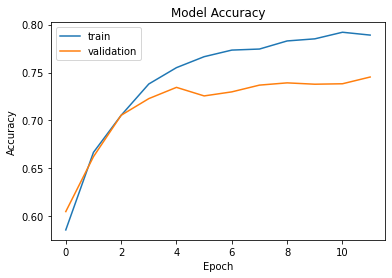

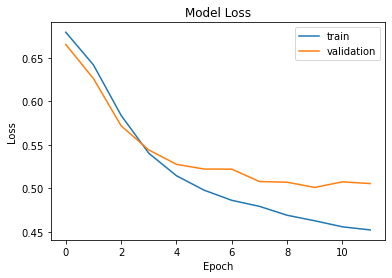

In [15]:
# LSTM model

model_LSTM, test_padded_LSTM = get_model(variant='lstm', batch_size=100, hidden_neurons=75, SEQ_LEN=51, learning_rate=0.0001)

## GRU (with RNN's optimal parameters):

* Similar to the LSTM model, here too we can see significant bump in the model's accuracy on the validation set.
* GRU is sort of a simplified version of the LSTM, even though it may not have dedicated memory units, it still manages to learn a lot of dependencies.
* Number of trainable parameters are higher than vanilla RNN, but lower than LSTM.

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 51, 300)           4524300   
_________________________________________________________________
gru (GRU)                    (None, 75)                84825     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 76        
Total params: 4,609,201
Trainable params: 84,901
Non-trainable params: 4,524,300
_________________________________________________________________
None
Epoch 1/15
64/64 - 3s - loss: 0.6879 - accuracy: 0.5458 - val_loss: 0.6771 - val_accuracy: 0.5699
Epoch 2/15
64/64 - 2s - loss: 0.6586 - accuracy: 0.6086 - val_loss: 0.6594 - val_accuracy: 0.6032
Epoch 3/15
64/64 - 2s - loss: 0.6370 - accuracy: 0.6366 - val_loss: 0.6423 - val_accuracy: 0.6323
Epoch 4/15
64/64 - 2s - loss: 0.6141 - accuracy: 0.6671 - val_loss: 0

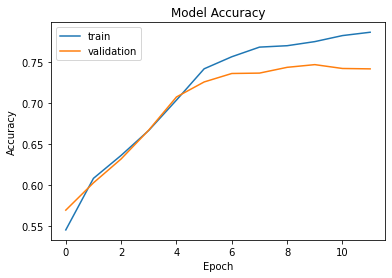

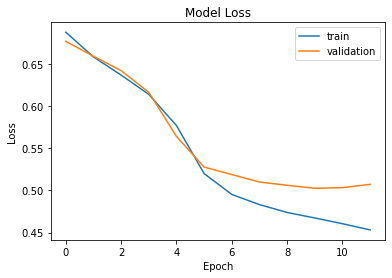

In [16]:
# GRU model

model_GRU, test_padded_GRU = get_model(variant='gru', batch_size=100, hidden_neurons=75, SEQ_LEN=51, learning_rate=0.0001)

# Evaluating on test dataset:

1. Vanilla RNN model
2. LSTM model
3. GRU model

In [17]:
# testing on the Vanilla RNN model

run_on_test(variant='Vanilla RNN', model=model_RNN, test_padded=test_padded_RNN)

Result on the test set for RNN variant - Vanilla RNN:

Test loss and accuracy is:
67/67 [==============================] - 0s 4ms/step - loss: 0.5367 - accuracy: 0.7329

Precision: 0.7396335583413693 
Recall: 0.7188378631677601 
F1-Score: 0.7290874524714829


In [18]:
# testing on the LSTM model

run_on_test(variant='LSTM', model=model_LSTM, test_padded=test_padded_LSTM)

Result on the test set for RNN variant - LSTM:

Test loss and accuracy is:
67/67 [==============================] - 1s 8ms/step - loss: 0.5135 - accuracy: 0.7559

Precision: 0.8013245033112583 
Recall: 0.6804123711340206 
F1-Score: 0.7359351241763812


In [19]:
# testing on the GRU model

run_on_test(variant='GRU', model=model_GRU, test_padded=test_padded_GRU)

Result on the test set for RNN variant - GRU:

Test loss and accuracy is:
67/67 [==============================] - 1s 8ms/step - loss: 0.5166 - accuracy: 0.7549

Precision: 0.7419928825622776 
Recall: 0.781630740393627 
F1-Score: 0.761296211775445


# Test data analysis for all models:

* Looking at the test data results, overall all three models were able to make pretty significant improvements after running for at maximum 15 number of epochs.
* But we have some interesting differences to note between them.
* The LSTM and GRU models managed to get more accurate overall on the training, validation as well as the test set. This can also be seen in the F1-score (which is dependent on the precision and recall) of the three models.
* This could be attributed to the ability of these networks to learn long term information from the data sequence.
* But that does't mean they are clear winners for this dataset. Due to the inherent architecture of LSTM and GRU models, they are more complex and have more parameters to train.
* For vanilla RNN, we have approximately 28k trainable parameters (run 1 of RNN), but for LSTM, we have around 112k trainable parameters and 84k for GRU.
* Hence, vanilla RNN is not only easier to train, but will also use less memory. Where vanilla RNN takes around 2 seconds, the others take around 6 seconds for each epoch of training on my machine.
* So, if I had to choose between the three, I would choose the GRU network, as it not only has better results (sometimes even better than LSTM) in terms of accuracies and the F-1 score, but also uses significantly less number of parameters than the LSTM.
* Choosing GRU, we get best of both worlds, good results as well as low resource use (compared to LSTM) while training and storing the model.
* I feel LSTM would be more appropriate for longer and complex data sequences, where the memory units would really shine in storing long term dependencies (advantageous over the vanishing gradient problem of the vanilla RNN). Though GRU is sufficient for the current dataset.
